# Machine Learning with Spark - Lab

## Introduction

Previously you saw how to manipulate data with Spark DataFrames as well as create machine learning models. In this lab, you're going to practice loading data, manipulating it, preparing visualizations, and fitting it in the Spark MLlib framework. Let's get started!

### Objectives

In this lab you will: 

- Load and manipulate data using Spark DataFrames 
- Create a Spark ML pipeline that transforms data and runs over a grid of hyperparameters 

## The Data

This dataset is from a Taiwanese financial company, and the task is to determine which individuals are going to default on their credit card based off of characteristics such as limit balance, past payment history, age, marriage status, and sex.

You'll use the file `credit_card_default.csv`, which comes from the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

## Initial Data Exploration

Get started by writing the relevant import statement and creating a local SparkSession called `spark`, then use that SparkSession to read `credit_card_default.csv` into a Spark SQL DataFrame.

In [1]:
# import necessary libraries
from pyspark.sql import SparkSession

# initialize Spark Session
spark = SparkSession.builder.master('local').getOrCreate()

# read in csv to a spark dataframe
spark_df = spark.read.csv("credit_card_default.csv", header="true", inferSchema="true")

24/01/13 14:03:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Use `.head()` to display the first 5 records, and print out the schema.

In [2]:
# Display the first 5 records
spark_df.head()

Row(ID=2, LIMIT_BAL=120000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682.0, BILL_AMT2=1725.0, BILL_AMT3=2682.0, BILL_AMT4=3272.0, BILL_AMT5=3455.0, BILL_AMT6=3261.0, PAY_AMT1=0.0, PAY_AMT2=1000.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=0.0, PAY_AMT6=2000.0, default=1)

In [3]:
# Print out the schema
spark_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- EDUCATION: string (nullable = true)
 |-- MARRIAGE: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: double (nullable = true)
 |-- BILL_AMT2: double (nullable = true)
 |-- BILL_AMT3: double (nullable = true)
 |-- BILL_AMT4: double (nullable = true)
 |-- BILL_AMT5: double (nullable = true)
 |-- BILL_AMT6: double (nullable = true)
 |-- PAY_AMT1: double (nullable = true)
 |-- PAY_AMT2: double (nullable = true)
 |-- PAY_AMT3: double (nullable = true)
 |-- PAY_AMT4: double (nullable = true)
 |-- PAY_AMT5: double (nullable = true)
 |-- PAY_AMT6: double (nullable = true)
 |-- default: integer (nullable = true)



It looks like we have three non-numeric features. For each non-numeric (`string`) feature, select and show all distinct categories.

In [4]:
# Select and show all distinct categories
for i in ["SEX","EDUCATION","MARRIAGE"]:
    spark_df.select(i).distinct().show()

+------+
|   SEX|
+------+
|Female|
|  Male|
+------+

+-----------+
|  EDUCATION|
+-----------+
|High School|
|          0|
|          5|
|          6|
|      Other|
|   Graduate|
|    College|
+-----------+

+--------+
|MARRIAGE|
+--------+
|       0|
|   Other|
| Married|
|  Single|
+--------+



Interesting...it looks like we have some extraneous values in our categories. For example both `EDUCATION` and `MARRIAGE` have a category `0`.

Let's create some visualizations of each of these to determine just how many of them there are.

Create bar plots of the variables `EDUCATION` and `MARRIAGE` to see how the records are distributed between the categories.

<details>
    <summary><u>Click to reveal hint</u></summary>
    
To create a bar plot, you need to group by the category (`.groupBy()`) and then aggregate by the count in that category (`.count()`). That will result in a small DataFrame containing `EDUCATION` and `count` columns.
    
Then the easiest way to create a bar plot is to call `.toPandas()` to make that small Spark SQL DataFrame into a pandas DataFrame, and call `.plot()` on the pandas DataFrame.

</details>

<BarContainer object of 7 artists>

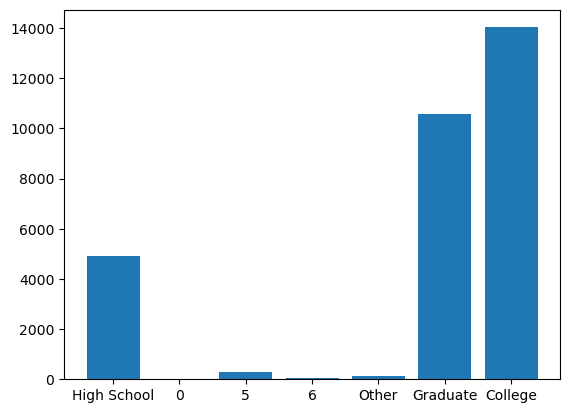

In [5]:
# Create bar plot of EDUCATION
import matplotlib.pyplot as plt
ed_grouped = spark_df.groupBy("EDUCATION").count()
ed_df = ed_grouped.toPandas()
plt.bar(ed_df['EDUCATION'],height=ed_df['count'])

<BarContainer object of 4 artists>

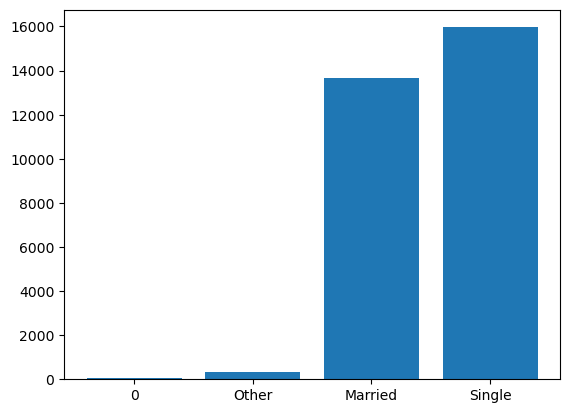

In [6]:
# Create bar plot of MARRIAGE
marriage_grouped = spark_df.groupBy("MARRIAGE").count()
marriage_df = marriage_grouped.toPandas()
plt.bar(marriage_df['MARRIAGE'],height=marriage_df['count'])

## Binning

It looks like there are barely any records in the `0`, `5`, and `6` categories. Let's go ahead and bin (combine) those with the current `Other` records into a single catch-all `Other` category for both `EDUCATION` and `MARRIAGE`.

The approach we'll use is similar to the `CASE WHEN` technique in SQL. If this were a SQL query, it would look something like this:

```sql
SELECT CASE
       WHEN EDUCATION = '0' THEN 'Other'
       WHEN EDUCATION = '5' THEN 'Other'
       WHEN EDUCATION = '6' THEN 'Other'
       ELSE EDUCATION
       END AS EDUCATION
  FROM credit_card_default;
```

With Spark SQL DataFrames, this is achieved using `.withColumn()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html)) in conjunction with `.when()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.when.html)) and `.otherwise()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.otherwise.html)).

In [7]:
from pyspark.sql.functions import when
# Bin EDUCATION categories
spark_df = spark_df.withColumn("EDUCATION",when((spark_df["EDUCATION"] == '0') | (spark_df["EDUCATION"] == '5') | (spark_df["EDUCATION"] == '6'),'Other').otherwise(spark_df["EDUCATION"]))

# Bin MARRIAGE categories
spark_df = spark_df.withColumn("MARRIAGE",when(spark_df["MARRIAGE"] == '0','Other').otherwise(spark_df["MARRIAGE"]))

# Select and show all distinct categories for EDUCATION and MARRIGE again
for i in ["SEX","EDUCATION","MARRIAGE"]:
    spark_df.select(i).distinct().show()

+------+
|   SEX|
+------+
|Female|
|  Male|
+------+

+-----------+
|  EDUCATION|
+-----------+
|High School|
|      Other|
|   Graduate|
|    College|
+-----------+

+--------+
|MARRIAGE|
+--------+
|   Other|
| Married|
|  Single|
+--------+



Let's also re-create the plots from earlier, now that the data has been binned:

<BarContainer object of 4 artists>

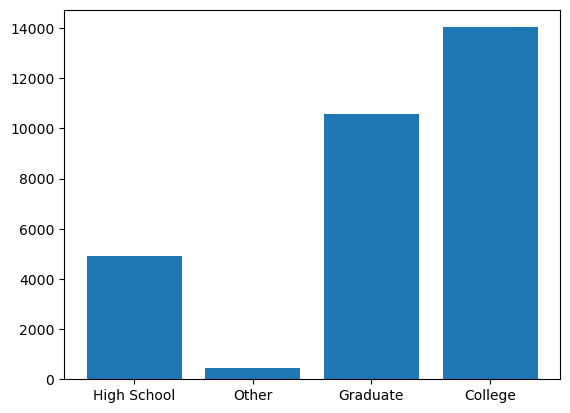

In [8]:
# Plot EDUCATION
ed_grouped = spark_df.groupBy("EDUCATION").count()
ed_df = ed_grouped.toPandas()
plt.bar(ed_df['EDUCATION'],height=ed_df['count'])

<BarContainer object of 3 artists>

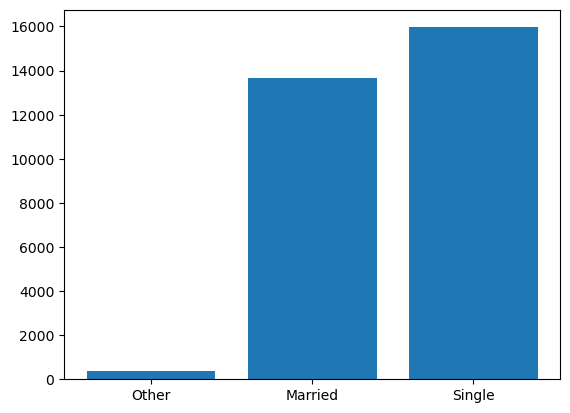

In [9]:
# Plot MARRIAGE
marriage_grouped = spark_df.groupBy("MARRIAGE").count()
marriage_df = marriage_grouped.toPandas()
plt.bar(marriage_df['MARRIAGE'],height=marriage_df['count'])

Much better. Now, let's do a little more investigation into our target variable before diving into the machine learning aspect of this project.

##  Class Balance Exploration

Let's first look at the overall distribution of class balance of the `default` column (the target for our upcoming machine learning process). 

Create a bar plot to compare the number of defaults (`0`) vs. non-defaults (`1`). Consider customizing your plot labels as well, since `0` and `1` are not particularly understandable values.

([<matplotlib.axis.XTick at 0x7fe4a8e461c0>,
 [Text(1, 0, 'defaults'), Text(0, 0, 'non-defaults')])

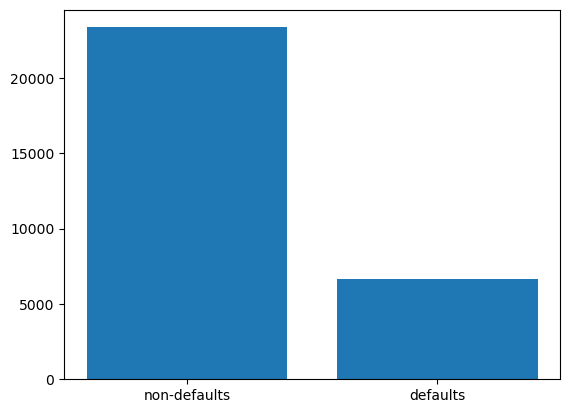

In [10]:
# Group and aggregate target data
target = spark_df.groupBy("default").count().toPandas()

# Plot target data
plt.bar(target['default'],height=target['count'])
plt.xticks(ticks=target['default'], labels=['defaults','non-defaults'])


Looks like we have a fairly imbalanced dataset.

Let's also visualize the difference in default rate between males and females in this dataset. Group by both `default` and `SEX` and visualize the comparison.

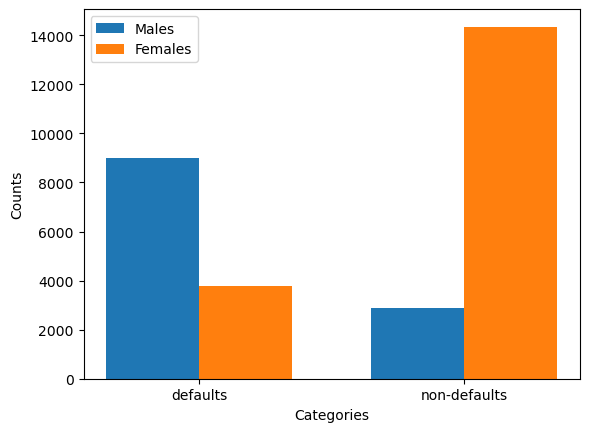

In [11]:
# Group and aggregate target and sex data
import numpy as np
sex_df = spark_df.groupBy(['default','SEX']).count().toPandas()
# Plot target and sex data
x = np.arange(len(sex_df['default'].unique()))

males = sex_df.loc[sex_df['SEX']=='Male']
females = sex_df.loc[sex_df['SEX']=='Female']

# Width of a bar
width = 0.35

# Creating the bar plot
plt.bar(x - width/2, males['count'], width, label='Males')
plt.bar(x + width/2, females['count'], width, label='Females')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(x, ['defaults','non-defaults'])
plt.legend()

# Display the plot
plt.show()

In [12]:
spark_df.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default']

It looks like males have an ever so slightly higher default rate than females, and also represent a smaller proportion of the dataset.

## On to the Machine Learning!

Now, it's time to fit the data to the PySpark machine learning model pipeline. You will need:

* 3 `StringIndexer`s
  * One for each categorical feature
  * [Documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html)
* A `OneHotEncoder`
  * To encode the newly indexed strings into categorical variables
  * [Documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.OneHotEncoder.html)
* A `VectorAssembler`
  * To combine all features into one `SparseVector`
  * [Documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html)

All of these initialized estimators should be stored in a list called `stages`.

In [13]:
# Import the necessary classes
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Create the string indexers and determine the names of the numeric
# and indexed columns. Note that ID is an identifier and should NOT
# be included in the numeric columns
sex_indexer = StringIndexer(inputCol="SEX", outputCol="SEXIndex")
ed_indexer = StringIndexer(inputCol="EDUCATION", outputCol="EDUCATIONIndex")
marriage_indexer = StringIndexer(inputCol="MARRIAGE", outputCol="MARRIAGEIndex")
# Create a OneHotEncoder to encode the indexed string features
ohe = OneHotEncoder(inputCols= ["SEXIndex","EDUCATIONIndex","MARRIAGEIndex"], outputCols=["SEXIndexEncoded","EDUCATIONIndexEncoded","MARRIAGEIndexEncoded"],dropLast=True)

# Determine the names of the final list of features going into the model
features = ['LIMIT_BAL','SEXIndexEncoded', 'EDUCATIONIndexEncoded', 'MARRIAGEIndexEncoded', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 
            'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 
            'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Create a VectorAssembler to combine all features
vecAssembler = VectorAssembler(inputCols= features, outputCol="features")

# Corrected features list for VectorAssembler
features = ['LIMIT_BAL', 'SEXIndexEncoded', 'EDUCATIONIndexEncoded', 'MARRIAGEIndexEncoded', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 
            'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 
            'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

vecAssembler = VectorAssembler(inputCols=features, outputCol="features")


# Assemble a list of stages that includes all indexers, the one-hot
# encoder, and the vector assembler
stages_list =[sex_indexer, ed_indexer, marriage_indexer, ohe, vecAssembler]


Great! Now let's see if that worked. Let's investigate how it transforms your dataset. Put all of the stages in a Pipeline and fit it to your data. Look at the features column. Did you obtain the number of features you expected?

In [14]:
# Import relevant class
from pyspark.ml import Pipeline

# Instantiate a pipeline using stages list
pipeline = Pipeline(stages=stages_list)


# Fit and transform the data using the pipeline, then look at
# the size of the array in the 'features' column
transformed_df = pipeline.fit(spark_df).transform(spark_df)
first_row = transformed_df.select("features").first()
vector_size = len(first_row['features'])
print("Size of the array in 'features' column:", vector_size)

24/01/13 14:04:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Size of the array in 'features' column: 26


<details>
    <summary><u>Click to reveal answer</u></summary>
    
The pipeline should have produced a sparse vector with 29 features.

This comes from:
    
* 20 numeric features
* 3 one-hot encoded features with `dropLast=True`, containing
  * 1 SEX feature
  * 3 EDUCATION features
  * 2 MARRIAGE features

</details>

In [76]:
test = transformed_df.toPandas()

In [78]:
test.describe()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,SEXIndex,EDUCATIONIndex,MARRIAGEIndex
count,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,...,29999.000000,2.999900e+04,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000
mean,15001.000000,167489.238975,35.485883,-0.016767,-0.133838,-0.166172,-0.220641,-0.266142,-0.291043,51224.907964,...,5663.769292,5.921338e+03,5225.855695,4826.237741,4799.547618,5215.676423,0.221174,0.396280,0.727458,0.480416
std,8660.109699,129747.029798,9.217819,1.123760,1.197143,1.196878,1.169149,1.133162,1.149964,73636.581260,...,16563.524146,2.304123e+04,17607.229085,15666.396081,15278.535203,17777.736580,0.415044,0.489132,0.787209,0.524175
min,2.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7501.500000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.500000,...,1000.000000,8.330000e+02,390.000000,296.000000,253.500000,118.000000,0.000000,0.000000,0.000000,0.000000
50%,15001.000000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22382.000000,...,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000,0.000000,1.000000,0.000000
75%,22500.500000,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67092.000000,...,5006.000000,5.000000e+03,4505.000000,4013.500000,4032.000000,4000.000000,0.000000,1.000000,1.000000,1.000000
max,30000.000000,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,...,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000,1.000000,3.000000,2.000000


## Fitting Machine Learning Models
That looks good! Now let's go ahead and fit data to different machine learning models. To evaluate these models, you should use the `BinaryClassificationEvaluator`.

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol='prediction',
    labelCol='default',
    metricName='areaUnderROC'
)

### Logistic Regression

First, we'll try a `LogisticRegression` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html)):

* split the data into a train and test set. The basic structure of this is:
```
train, test = df.randomSplit(weights=[0.8, 0.2], seed=1)
```
  * make sure you replace `df` with the actual name of your prepared dataframe
* instantiate a logistic regression with `standardization=True` and add it to the stages list
* instantiate a new Pipeline estimator with all of the stages
* fit the pipeline on the training data
* transform both train and test data using the pipeline
* use `evaluator` to evaluate performance on train vs. test

In [16]:
from pyspark.ml.classification import LogisticRegression

# Your code here
train, test = spark_df.randomSplit(weights=[0.8, 0.2], seed=1)
logreg = LogisticRegression(labelCol="default",standardization=True)

stages_list2 =[sex_indexer, ed_indexer, marriage_indexer, ohe, vecAssembler,logreg]

pipe = Pipeline(stages=stages_list2)
model = pipe.fit(train)
train_transformed = model.transform(train)
test_transformed = model.transform(test)

train_roc_auc = evaluator.evaluate(train_transformed)
test_roc_auc = evaluator.evaluate(test_transformed)
print(f"Train Area under ROC: {train_roc_auc}")
print(f"Test Area under ROC: {test_roc_auc}")


24/01/13 14:04:27 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/01/13 14:04:27 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Train Area under ROC: 0.6058470056674641
Test Area under ROC: 0.6093921637168584


Looks like the defaults for `LogisticRegression` are working pretty well, since the train and test metrics are pretty similar.

Still, let's try a `CrossValidator` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)) + `ParamGridBuilder` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)) approach with a few different regularization parameters.

We'll use these regularization parameters:

```python
[0.0, 0.01, 0.1, 1.0]
```

In the cell below:

* instantiate a `ParamGridBuilder` that tests out the `regParam` values listed above
* instantiate a `CrossValidator` that uses the param grid you just created as well as `evaluator` and the pipeline you created earlier
* fit the `CrossValidator` on the full DataFrame
* display the metrics for all models, and identify the best model parameters

In [17]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Your code here
params = (ParamGridBuilder()
             .addGrid(logreg.regParam, [0.0, 0.01, 0.1, 1.0])
             .build())
cv = CrossValidator(estimator=pipe,
                    estimatorParamMaps=params,
                    evaluator=evaluator)

cvModel = cv.fit(spark_df)

In [63]:

type(cvModel)

pyspark.ml.tuning.CrossValidatorModel

In [61]:
bestModel = cvModel.bestModel.stages[5]
print("Best Model's Parameters and Values:")
for param, value in bestModel.extractParamMap().items():
    print(f"{param.name}: {value}")

Best Model's Parameters and Values:
aggregationDepth: 2
elasticNetParam: 0.0
featuresCol: features
fitIntercept: True
labelCol: default
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
standardization: True
threshold: 0.5
family: auto
maxIter: 100
regParam: 0.0
tol: 1e-06


In [72]:
for params, metric in zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics):
    print('Parameters:', params)
    print('Metric (average across folds):', metric)
    print('-' * 30)


Parameters: {Param(parent='LogisticRegression_4b8adc33f2f5', name='regParam', doc='regularization parameter (>= 0).'): 0.0}
Metric (average across folds): 0.6073958404847037
------------------------------
Parameters: {Param(parent='LogisticRegression_4b8adc33f2f5', name='regParam', doc='regularization parameter (>= 0).'): 0.01}
Metric (average across folds): 0.5953894073189682
------------------------------
Parameters: {Param(parent='LogisticRegression_4b8adc33f2f5', name='regParam', doc='regularization parameter (>= 0).'): 0.1}
Metric (average across folds): 0.5579130924178861
------------------------------
Parameters: {Param(parent='LogisticRegression_4b8adc33f2f5', name='regParam', doc='regularization parameter (>= 0).'): 1.0}
Metric (average across folds): 0.5047392379813508
------------------------------


Now try this again with other classifiers. Try and create a function that will allow you to easily test different models with different parameters. You can find all of the available classification model options [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#classification).

This function is optional, but it should allow for your code to be far more D.R.Y. The function should return the fitted cross-validated classifier as well as print out the AUC of the best-performing model and the best parameters.

In [65]:
# Create a function to cross validate different classifiers with different parameters
def cv_class(classifier, param_dict):
    stages_list2 =[sex_indexer, ed_indexer, marriage_indexer, ohe, vecAssembler,classifier]
    pipe = Pipeline(stages=stages_list2)
    paramGrid = ParamGridBuilder()
    for param, values in param_dict.items():
        paramGrid = paramGrid.addGrid(classifier.getParam(param),values)
    paramGrid = paramGrid.build()
    
    cv = CrossValidator(estimator=pipe,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator)
    
    cvModel = cv.fit(spark_df)
    max_index = cvModel.avgMetrics.index(max(cvModel.avgMetrics))
    best_score = cvModel.avgMetrics[max_index]
    best_params = cvModel.getEstimatorParamMaps()[max_index]
    print(f"Area under ROC: {best_score}")
    bestModel = cvModel.bestModel.stages[5]
    print("Best Model's Parameters and Values:")
    for param, value in bestModel.extractParamMap().items():
        print(f"{param.name}: {value}")
    return cvModel.bestModel

In [66]:
logreg = LogisticRegression(labelCol="default",standardization=True)
param_dict = {'regParam': [0.0, 0.01, 0.1, 1.0]}

cv_class(logreg, param_dict)

Area under ROC: 0.6068466893584137
Best Model's Parameters and Values:
aggregationDepth: 2
elasticNetParam: 0.0
featuresCol: features
fitIntercept: True
labelCol: default
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
standardization: True
threshold: 0.5
family: auto
maxIter: 100
regParam: 0.0
tol: 1e-06


PipelineModel_9267a8a24bf1

Now train one other classifier that is not a `LogisticRegression`. Use a `ParamGridBuilder` to try out some relevant parameters.

In [68]:
from pyspark.ml.classification import RandomForestClassifier
rtc = RandomForestClassifier(labelCol="default")
random_forest_params = {
    "numTrees": [10, 20, 50],  # Number of trees in the forest
    "maxDepth": [5, 10, 20],  # Maximum depth of the tree
    "maxBins": [32, 64, 100]  # Maximum number of bins used for discretizing continuous features
}
cv_class(rtc, random_forest_params)

24/01/13 15:06:45 WARN CacheManager: Asked to cache already cached data.
24/01/13 15:06:45 WARN CacheManager: Asked to cache already cached data.
24/01/13 15:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1149.5 KiB
24/01/13 15:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1542.6 KiB
24/01/13 15:07:06 WARN DAGScheduler: Broadcasting large task binary with size 1991.2 KiB
24/01/13 15:07:06 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/01/13 15:07:07 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/01/13 15:07:08 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/01/13 15:07:08 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/01/13 15:07:09 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/01/13 15:07:10 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/01/13 15:07:11 WARN DAGScheduler: Broadcasting large task binary wit

Area under ROC: 0.6549147657245615
Best Model's Parameters and Values:
featuresCol: features
labelCol: default
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -4511249652906740454
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
impurity: gini
leafCol: 
maxBins: 100
maxDepth: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 50
subsamplingRate: 1.0


PipelineModel_30ce7f1d6fe4

And one more:

In [71]:
# Your code here
# ⏰ This cell may take a long time to run
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="default")
gbt_params = {
    "maxIter": [10, 50, 100],  # Maximum number of iterations
    "maxDepth": [3, 5, 10],  # Maximum depth of the tree
    "stepSize": [0.01, 0.1, 0.2]  # Learning rate
}
cv_class(gbt, gbt_params)

24/01/13 15:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1035.6 KiB
24/01/13 15:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1029.8 KiB
24/01/13 15:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1030.3 KiB
24/01/13 15:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1031.0 KiB
24/01/13 15:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1032.0 KiB
24/01/13 15:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1034.3 KiB
24/01/13 15:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1038.9 KiB
24/01/13 15:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1047.9 KiB
24/01/13 15:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1065.7 KiB
24/01/13 15:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1094.9 KiB
24/01/13 15:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1143.4 KiB
24/01/13 15:27:59 WAR

Area under ROC: 0.6585846937585806
Best Model's Parameters and Values:
featuresCol: features
labelCol: default
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 2544616028232176056
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
impurity: variance
leafCol: 
lossType: logistic
maxBins: 32
maxDepth: 3
maxIter: 100
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
stepSize: 0.01
subsamplingRate: 1.0
validationTol: 0.01


PipelineModel_4c47c734c60a

In [72]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="default")
decision_tree_params = {
    "maxDepth": [3, 5, 10],  # Maximum depth of the tree
    "maxBins": [32, 64, 100],  # Maximum number of bins used for discretizing continuous features
    "minInstancesPerNode": [1, 2, 4]  # Minimum number of instances each child must have after split
}
cv_class(dt, decision_tree_params)

Area under ROC: 0.6590382216269018
Best Model's Parameters and Values:
featuresCol: features
labelCol: default
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 6431264276936430384
cacheNodeIds: False
checkpointInterval: 10
impurity: gini
leafCol: 
maxBins: 64
maxDepth: 3
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0


PipelineModel_728c48bfd285

Which classifier turned out to be the best overall?

In [ ]:
# Your answer here
"""Surprisingly the DecisionTreeClassifier performed the best, surprising as it was also the quickest to run. 
""";

## Level Up (Optional)

* Create ROC curves for each of these models
* Try the multi-layer perceptron classifier algorithm. You will soon learn about what this means in the neural network section!

## Stop the Spark Session

In [79]:
spark.stop()

## Summary

If you've made it this far, congratulations! Spark is an in-demand skill, but it is not particularly easy to master. In this lesson, you fit multiple different machine learning pipelines for a classification problem. If you want to take your Spark skills to the next level, connect to a distributed cluster using a service like AWS or Databricks and perform these Spark operations on the cloud.